In [31]:
from collections import defaultdict
from os import listdir
from os.path import isfile, join
import re
import pandas as pd
import numpy as np
import math
from scipy.ndimage import gaussian_filter
from itertools import cycle, product
from scipy.stats import poisson
from numpy import vectorize
import multiprocessing
from joblib import Parallel, delayed
import matplotlib.pyplot as plt 

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
TIME_BUCKET_LENGTH = .3
LOCATION_BUCKET_LENGTH = .25 # length is 1/LOCATION_BUCKET_LENGTH

# Concerns


The location data has sudden jumps that appear to be discontinouities when graphed out. Additionally, there is data for x and y positions, and both x and y vary to the degree expected if there were two degrees of freedom. I chose to use only x data for this reconstruction.

Does the calculation we did still hold if we have multiple spikes?

## Reading Data from Local Files

In [3]:
"""
SQL DISCOVERY QUERIES FOR METADATA (used to find e.g. all linear experiments)
select f.topdir, f.session from session s, file f where s.behavior = 'linear' and s.session=f.session 
order by f.topdir desc;
"""

"\nSQL DISCOVERY QUERIES FOR METADATA (used to find e.g. all linear experiments)\nselect f.topdir, f.session from session s, file f where s.behavior = 'linear' and s.session=f.session \norder by f.topdir desc;\n"

In [4]:
"""
| Record data from channels (amplify by 1000x, record at 20Khz (20,000Hz) or 32,552Hz sample
 | rate, bandpass 1-5kHz). Recordings made by either DataMax recording device
 | (DataMax system; RC Electronics) at 20kHz, or a NeuraLynx recording device
 | (NeuraLynx system) at 32,552Hz. Data sets recorded using DataMax (20KHz) are:
 | ec012, ec013, ec014, ec016, f01_m, g01_m, i01_m, j01_m. Data sets recorded using
 | NeuraLynx (32,552Hz) are: gor01, pin01, vvp01, ec014 (ec014.n329 only, all other
 | sessions from rat ec014 were recorded by DataMax). The sampling frequency is also
 | available in .xml files.
"""
def get_freq(session_dir):
    frequency_is_32552 = ["gor01*", "pin01*", "vvp01*", "ec014\.n329*"]
    frequency_is_32552 = [re.compile(x) for x in frequency_is_32552]
    for freq_reg in frequency_is_32552:
        if freq_reg.match(session_dir):
            return 32552
    return 20000

In [5]:
linear_experiments = {'ec016.59': ['ec016.1047'],
 'ec016.53': ['ec016.931'],
 'ec016.49': ['ec016.850'],
 'ec016.45': ['ec016.749'],
 'ec016.44': ['ec016.733'],
 'ec016.41': ['ec016.674'],
 'ec016.19': ['ec016.269'],
 'ec016.17': ['ec016.233', 'ec016.234'],
 'ec014.36': ['ec014.639'],
 'ec014.29': ['ec014.468'],
 'ec013.56': ['ec013.978', 'ec013.979', 'ec013.980'],
 'ec013.55': ['ec013.965', 'ec013.966', 'ec013.969'],
 'ec013.54': ['ec013.949', 'ec013.950', 'ec013.951'],
 'ec013.53': ['ec013.932', 'ec013.933', 'ec013.934'],
 'ec013.51': ['ec013.906', 'ec013.910', 'ec013.911'],
 'ec013.49': ['ec013.874', 'ec013.880', 'ec013.881', 'ec013.882'],
 'ec013.48': ['ec013.859', 'ec013.860', 'ec013.861'],
 'ec013.47': ['ec013.840', 'ec013.842', 'ec013.843'],
 'ec013.45': ['ec013.799', 'ec013.805', 'ec013.806', 'ec013.807'],
 'ec013.44': ['ec013.788'],
 'ec013.42': ['ec013.761', 'ec013.762', 'ec013.764'],
 'ec013.41': ['ec013.737', 'ec013.738', 'ec013.739'],
 'ec013.40': ['ec013.718', 'ec013.719', 'ec013.720'],
 'ec013.39': ['ec013.683', 'ec013.684', 'ec013.685'],
 'ec013.38': ['ec013.669', 'ec013.670', 'ec013.671'],
 'ec013.37': ['ec013.639', 'ec013.642', 'ec013.643'],
 'ec013.36': ['ec013.626', 'ec013.627', 'ec013.628'],
 'ec013.35': ['ec013.589', 'ec013.599', 'ec013.600', 'ec013.601'],
 'ec013.34': ['ec013.573', 'ec013.574', 'ec013.576'],
 'ec013.33': ['ec013.554', 'ec013.555', 'ec013.556'],
 'ec013.32': ['ec013.531', 'ec013.532', 'ec013.533'],
 'ec013.31': ['ec013.502', 'ec013.503', 'ec013.504'],
 'ec013.30': ['ec013.454', 'ec013.465', 'ec013.466', 'ec013.469'],
 'ec013.29': ['ec013.440', 'ec013.441', 'ec013.442'],
 'ec013.28': ['ec013.395', 'ec013.412', 'ec013.413', 'ec013.414'],
 'ec013.27': ['ec013.374', 'ec013.375', 'ec013.386', 'ec013.387', 'ec013.388'],
 'ec013.21': ['ec013.251', 'ec013.252'],
 'ec013.18': ['ec013.205', 'ec013.206', 'ec013.208'],
 'ec013.15': ['ec013.156', 'ec013.157'],
 'ec012ec.27': ['ec012ec.560', 'ec012ec.561'],
 'ec012ec.24': ['ec012ec.503', 'ec012ec.504'],
 'ec012ec.22': ['ec012ec.465', 'ec012ec.466', 'ec012ec.467'],
 'ec012ec.21': ['ec012ec.444', 'ec012ec.445'],
 'ec012ec.18': ['ec012ec.374', 'ec012ec.375'],
 'ec012ec.17': ['ec012ec.356', 'ec012ec.357'],
 'ec012ec.14': ['ec012ec.269', 'ec012ec.270', 'ec012ec.271'],
 'ec012ec.13': ['ec012ec.239', 'ec012ec.240']}

In [6]:
def get_datadirs(testing=True):
    dirs = defaultdict(list)
    if testing:
        dirs["ec013"].append('data/ec013.40/ec013.719/')
    else:
        for key, value in linear_experiments.iteritems():
            for session in value:
                dirs[key[:5]].append('data/' + key + '/' + session + '/')
    return dirs

In [7]:
data = defaultdict(lambda: {})
# parse time, location, and spike data for each electrode
animal_dirs = get_datadirs()
dirs = [item for sublist in animal_dirs.values() for item in sublist]
for session_dir in dirs:
    location_reg = re.compile(".*\.whl")
    time_reg = re.compile(".*\.res\.*")
    cluster_reg = re.compile(".*\.clu\.*")
    freq = get_freq(session_dir)
    files = [f for f in listdir(session_dir) if isfile(join(session_dir, f))]
    data_files = defaultdict(list)
    for file in files:
        if location_reg.match(file):
            location_df = pd.read_csv(join(session_dir, file), delimiter='\t', header=None)
            location_df['time'] = location_df.index / 39.0625
            location_df['time'] = pd.to_timedelta(location_df['time'], unit="sec")
#             location_df.drop_duplicates(subset=[0,1,2,3], keep=False, inplace=True)
            data[session_dir]['location'] = location_df
        elif time_reg.match(file):
            electrode_num = int(file.rsplit('.', 1)[1])
            time_series = pd.read_csv(join(session_dir, file), delimiter='\n', header=None, squeeze=True)
            time_series /= freq
            time_series = pd.to_timedelta(time_series, unit="sec")
            if electrode_num not in data[session_dir]:
                data[session_dir][electrode_num] = pd.DataFrame()
            data[session_dir][electrode_num]['time'] = time_series
        elif cluster_reg.match(file):
            electrode_num = int(file.rsplit('.', 1)[1])
            series = pd.read_csv(join(session_dir, file), delimiter='\n', header=None, squeeze=True)
            n_clusters = series.iloc[0]
            series = series.iloc[1:]
            series.reset_index(drop=True, inplace=True)
            if electrode_num not in data[session_dir]:
                data[session_dir][electrode_num] = pd.DataFrame()
            data[session_dir][electrode_num]['spikes'] = series
            
# combine data from each electrode into one concantenated dataframe
concantenated_data = {}
for session, session_data in data.items():
    concantenated_spikes = pd.DataFrame(columns=['spikes', 'time'])
    for electrode_num, spike_data in session_data.items():
        if electrode_num == "location":
            continue
        spike_data['spikes'] = spike_data['spikes'].apply(lambda x: str(electrode_num) + '-' + str(x))
        concantenated_spikes = pd.concat([concantenated_spikes, spike_data], ignore_index=True)
    concantenated_spikes
    concantenated_data[session] = concantenated_spikes.sort_values('time').reset_index(drop=True)

In [8]:
# https://crcns.org/forum/using-datasets/62983963#926694452 - sampling rate of .whl is 39.06 Hz

## Bucketing Data into Time and Location Bins

In [9]:
def bucket_spikes(spike_train, bucket_size=TIME_BUCKET_LENGTH):
    spike_train.loc[len(spike_train)-1] = [float('nan'), pd.Timedelta(0, unit="sec")]
    spike_train = spike_train.sort_values('time').reset_index(drop=True)
    binned = spike_train.groupby(pd.Grouper(key='time', freq='{}S'.format(bucket_size), 
                                            base=spike_train['time'][0].seconds))
    binned = binned['spikes'].apply(lambda x: x.value_counts())
    binned = pd.DataFrame(binned).unstack(fill_value=0)
    binned.columns = binned.columns.droplevel()
    binned = binned.reindex(sorted(binned.columns), axis=1)
    binned.columns = list(range(len(binned.columns)))
    return binned

def x_round(x, round_num):
    if x < 0 or np.isnan(x):
        return x
    return round(x*round_num)/round_num

def bucket_location(locations, bucket_size=TIME_BUCKET_LENGTH, location_bucket_length=LOCATION_BUCKET_LENGTH):
    location_bucket_length = 1.0/location_bucket_length
    locations.loc[len(locations)-1] = ([float('nan')] * (len(locations.columns)-1))+ [pd.Timedelta(0, unit="sec")]
    locations = locations.sort_values('time').reset_index(drop=True)
    locations = locations.groupby(pd.Grouper(key='time', freq='{}S'.format(bucket_size)))
    locations = pd.DataFrame(locations.mean())
    locations = locations.fillna(method='ffill')
    bucketed_locs = locations.apply(lambda x: x.apply(lambda y: x_round(y, location_bucket_length)))
    # remove locations with no measurement, 
    bucketed_locs[0] = bucketed_locs[0].apply(lambda x: np.nan if x == -1 or x == 0 else x)
    locations[0] = locations[0].apply(lambda x: np.nan if x == -1 or x == 0 else x)
    # make min location 0
    bucketed_locs[0] -= bucketed_locs[0].min()
    locations[0] -= locations[0].min()
    return locations, bucketed_locs

In [10]:
bucketed = {}
# average time between spikes is 0.002s, time between location measurements is 0.02s
times = [10, 5, 2, 1, 0.5, 0.3, 0.1, 0.03, 0.02, 0.01] 
# 25th percentile length difference is 0.1cm
lengths = [50, 25, 10, 5, 2, 1, 0.5, 0.2, 0.25, 0.1, 0.05]
times = [0.3]
lengths = [0.25]
for time, length, directory in product(times, lengths, dirs):
    if (time, length, directory) not in bucketed:
        bucketed_spikes = bucket_spikes(concantenated_data[directory], time)
        locs, bucketed_locs = bucket_location(data[directory]['location'], time, length)

        bucketed_spikes['location'] = bucketed_locs[0]
        bucketed_spikes['unbucketed_location'] = locs[0]
        bucketed_spikes = bucketed_spikes.dropna()
        bucketed[time, length, directory] = bucketed_spikes

## Computing Distribution of Animal Locations

In [48]:
# animal_location = {}
# for animal in animal_dirs.keys():
#     locations = []
#     for directory in animal_dirs[animal]:
#         location = bucketed[.01, 50, directory].unbucketed_location
#         locations += list(location)
#     animal_location[animal] = np.around(np.array(locations), 2)

In [ ]:
# a = np.histogram(animal_location['ec013'])

In [ ]:
# _ = plt.hist(animal_location['ec013'], bins='auto')

## Plotting Trajectory with Spikes Overlayed

In [12]:
%matplotlib inline
def plot_spikes_for_neuron(df, neuron):
    plt_df = df.copy(deep=True)
    plt_df.index = plt_df.index.total_seconds()
    plt_df.location.plot()
    cycol=cycle('bgrcmky')
    spikes_at_location = plt_df.loc[plt_df[neuron][plt_df[neuron] > 0].index]
    plt.scatter(spikes_at_location.index, spikes_at_location.location.values)
    plt.ylabel('Location in cm')
    plt.xlabel('Time in s')
    plt.title('Time vs Location for Neuron {}'.format(neuron))
    plt.show()

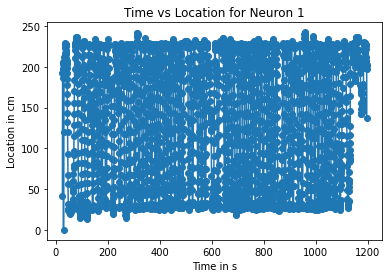

In [14]:
neurons = [1]#,10,20,30,40,50,60,70,80]
%matplotlib inline
df = bucketed[0.3, 0.25, 'data/ec013.40/ec013.719/']
for neuron in neurons:
    plot_spikes_for_neuron(df, neuron)

## Calculating Place Fields

In [68]:
def poisson_mean(df, i, x, time_bucket_length):
    return df[df.location==x][i].sum()/(len(df[df.location==x]) * time_bucket_length)

def calculate_poisson(df, locations, time_bucket_length):
    poisson = {}
    for x_k in locations:
        for i in list(df.columns[:-2]):
            pm = poisson_mean(df, i, x_k, time_bucket_length)
            poisson[i, x_k] = pm
    return poisson

def calculate_smoothed_poisson(df, locations, time_bucket_length):
    poisson_dic = calculate_poisson(df, locations, time_bucket_length)
    poisson_series = pd.Series(poisson_dic).reset_index()
    poisson_series.columns = ['neuron', 'location', 'poisson_mean']
    poisson_series = poisson_series.sort_values(['neuron', 'location']).reset_index(drop=True)
    estimated_place_fields = np.array(poisson_series.pivot(index='neuron',columns='location'))
    smoothed_place_fields = np.apply_along_axis(lambda x: gaussian_filter(x, sigma=40), 1, estimated_place_fields)
    dic = {}
    xaxis = sorted(locations)
    for neuron in range(smoothed_place_fields.shape[0]):
        for i in range(smoothed_place_fields.shape[1]):
            dic[neuron, xaxis[i]] = smoothed_place_fields[neuron,i]
    return dic

## Plotting Place Fields by Neuron

In [52]:
poisson_series = pd.Series(poisson_dic).reset_index()
poisson_series.columns = ['neuron', 'location', 'poisson_mean']
poisson_series = poisson_series.sort_values(['neuron', 'location']).reset_index(drop=True)
estimated_place_fields = np.array(poisson_series.pivot(index='neuron',columns='location'))
smoothed_place_fields = np.apply_along_axis(lambda x: gaussian_filter(x, sigma=40), 1, estimated_place_fields)

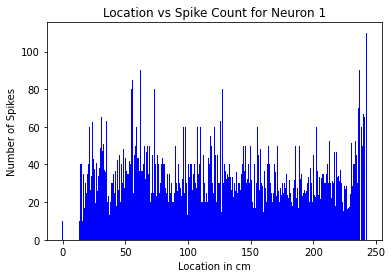

In [27]:
%matplotlib inline
df = bucketed[0.3, 0.25, 'data/ec013.40/ec013.719/']
poisson_dic = calculate_poisson(df, list(set(df.location)), TIME_BUCKET_LENGTH)
df_pos = pd.DataFrame(poisson_dic.values(), index=poisson_dic.keys())
df_pos = df_pos.reset_index()
df_pos.columns = ['neuron', 'location', 'spikes']
cycol=cycle('bgrcmky')
for neuron in neurons:
    vals = df_pos[df_pos['neuron'] == neuron].sort_values('location')
    plt.bar(vals.location, vals.spikes, color=next(cycol), label=str(neuron))
    plt.ylabel('Number of Spikes')
    plt.xlabel('Location in cm')
    plt.title('Location vs Spike Count for Neuron {}'.format(neuron))
    plt.show()

## Maximum Likelihood Estimators

In [17]:
def MLE_p(neurons, spikes, x, time_bucket_length, poisson):
    # poisson pre-calculated
    max_val = float('-inf')
    max_x = -1
    for x_k in x:
        sum_val = 0
        for i in neurons:
            if (i, x_k) in poisson:
                pm = poisson[i, x_k]
                if pm:
                    sum_val += (spikes[i] * math.log(pm*time_bucket_length)) - (pm*time_bucket_length)
        if sum_val > max_val:
            max_x = x_k
            max_val = sum_val
    return max_x


def location_transition_prob(x_0, x_1, v, K, V, d):
    sigma = K * ((v/V) ** d)
    prob = (1/(sigma * ((2 * math.pi) ** 0.5)))
    prob *= math.e ** (-0.5 * (((x_1 - x_0)/sigma) ** 2))
    if prob == 0:
        # floating point arithmetic limitations cause errors later on when taking logs
        prob = 1e-28
    return prob
    
def get_average_speeds(df, locations):
    average_speed = {}
    no_speed_data = []
    for location in locations:
        at_loc = list(np.where(df.location == location)[0])
        if(len(at_loc) < 2):
            no_speed_data.append(location)
            continue
        speed = 0
        for loc in at_loc:
            if loc == 0:
                speed += abs(df.location.iloc[1] - df.location.iloc[0])
            elif loc == len(df) - 1:
                speed += abs(df.location.iloc[-1] - df.location.iloc[-2])
            else:
                speed += abs(df.location.iloc[loc + 1] - df.location.iloc[loc - 1])
        speed /= len(at_loc)
        average_speed[location] = speed
        if speed == 0:
            no_speed_data.append(location)
    overall_avg_speed = np.mean(list(average_speed.values()))
    for location in no_speed_data:
        average_speed[location] = overall_avg_speed
    return average_speed

def MLE_continuity_constraint(neurons, spikes, average_speed, x, x_last, K, V, d, time_bucket_length, poisson):
    # poisson pre-calculated
    max_val = float('-inf')
    max_x = -1
    for x_k in x:
        sum_val = 0
        for i in neurons:
            if (i, x_k) in poisson:
                pm = poisson[i, x_k]
                if pm:
                    sum_val += (spikes[i] * math.log(pm*time_bucket_length)) - (pm*time_bucket_length)
        transition_prob = location_transition_prob(x_last, x_k, average_speed[x_k], K, V, d)
        sum_val += math.log(transition_prob)
        if sum_val > max_val:
            max_x = x_k
            max_val = sum_val
    return max_x

## Mean Squared Error calculators

In [66]:
def MSE(df, time_bucket_length, predict=True):
    train, val, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
    error = 0
    locations = list(set(df.location))
    poisson = calculate_smoothed_poisson(train, locations, time_bucket_length)
    neurons = list(df.columns[:-2])
    if predict:
        predictions = []
        for index, row in df.iterrows():
            x_pred = MLE_p(neurons, row[:-2], locations, time_bucket_length, poisson)
            predictions.append((index, x_pred))
            if len(predictions) >= len(train) and len(predictions) <= len(train) + len(val):
                error += (row.iloc[-1] - x_pred) ** 2
        error /= len(val)
        return error, predictions
    for index, row in val.iterrows():
        x_pred = MLE_p(neurons, row[:-2], locations, time_bucket_length, poisson)
        error += (row.iloc[-1] - x_pred) ** 2
    error /= len(val)
    return error

def MSE_continuity_constraint(df, time_bucket_length, K=15, V=20, d=0.5, predict=True):
    train, val, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
    error = 0
    locations = list(set(df.location))
    average_speed = get_average_speeds(train, locations)
    poisson = calculate_smoothed_poisson(train, locations, time_bucket_length)
    neurons = list(df.columns[:-2])
    if predict:
        predictions = []
        for index, row in df.iterrows():
            x_pred = 0
            if len(predictions) == 0:
                x_pred = MLE_p(neurons, row[:-2], locations, time_bucket_length, poisson)
            else:
                x_pred = MLE_continuity_constraint(neurons, row[:-2], average_speed,
                                               locations, predictions[-1][1], K, V, d, time_bucket_length, poisson)
            predictions.append((index, x_pred))
            if len(predictions) >= len(train) and len(predictions) <= len(train) + len(val):
                error += (row.iloc[-1] - x_pred) ** 2
        error /= len(val)
        return error, predictions
    pred_count = 0
    for index, row in val.iterrows():
        x_pred = 0
        if pred_count == 0:
            x_pred = MLE_p(neurons, row[:-2], locations, time_bucket_length, poisson)
        else:
            x_pred = MLE_continuity_constraint(neurons, row[:-2], average_speed,
                                           locations, predictions[-1][1], K, V, d, time_bucket_length, poisson)
        error += (row.iloc[-1] - x_pred) ** 2
        pred_count += 1
    error /= len(val)
    return error

def calculate_MSE(time, length, directory):
    if (time, length, directory) not in bucketed:
        bucketed_spikes = bucket_spikes(concantenated_data[directory], time)
        locs, bucketed_locs = bucket_location(data[directory]['location'], time, length)
        bucketed_locs[0] = bucketed_locs[0].apply(lambda x: np.nan if x == -1 or x == 0 else x)
        locs[0] = locs[0].apply(lambda x: np.nan if x == -1 or x == 0 else x)
        bucketed_spikes['location'] = bucketed_locs[0]
        bucketed_spikes['unbucketed_location'] = locs[0]
        bucketed_spikes = bucketed_spikes.dropna()
        bucketed[time, length, directory] = bucketed_spikes

    df = bucketed[time, length, directory]
    error, _ = MSE(df, time)
    error_cc, _ = MSE_continuity_constraint(df, time)
    print(time, length, error, error_cc)
    print("Time = {}s, length = {}cm, error = {:.2f}, error_cc = {:.2f}".format(time, length, error, error_cc))
    return [time, length, error, error_cc]

In [69]:
df = bucketed[0.3, 0.25, 'data/ec013.40/ec013.719/']
error_cc, predictions_cc = MSE_continuity_constraint(df, 0.3)
error, predictions = MSE(df, 0.3)
predictions_cc = pd.DataFrame(predictions_cc)
predictions = pd.DataFrame(predictions)
predictions["cc"] = predictions_cc[1]
predictions.columns = ['time', 'MLE', 'MLE CC']
predictions = predictions.set_index('time', drop=True)
predictions['Ground Truth'] = df["unbucketed_location"]

/Users/kushagrasharma/.pyenv/versions/jupyter3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [70]:
train, val, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

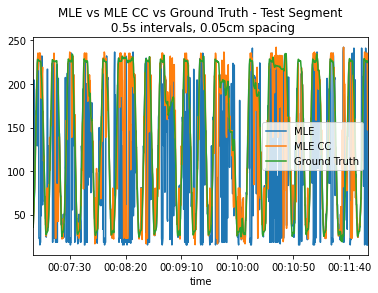

In [21]:
predictions.iloc[msk:msk+1000].plot.line(title="MLE vs MLE CC vs Ground Truth - Test Segment\n {}s intervals, {:.2f}cm spacing".format(0.5, 0.05))
plt.show()